# Question Answering system over Knowledge Graphs


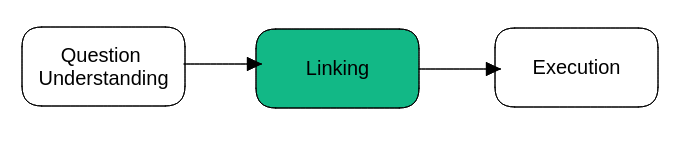



QA system pipeline generally consists of 3 modules where the first module parses the question for **question understanding** to extract entities and relations from the question. The second module **maps the extracted information to vertices and edges in a knowledge graph** and the last module creates a SPARQL query and executes it. The second module relates to a workload where mapping the information from a question to the knowledge graph requires multiple independent lightweight processes. Currently, the system is not efficient as the average time taken to run the system on a benchmark is 4.5 hours (16 seconds per question). We are mainly focussing on making QA system more efficient by:

1. Parallelly processing questions on the benchmarks
2. Dealing with different entities and relations from the same question in parallel
3. Parallelizing the similarity search for linking


## **Installing the required libraries**

In [2]:
!pip install allennlp
!pip install allennlp-models
!pip install pyspark

     |████████████████████████████████| 719 kB 6.9 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 248 kB 54.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 125 kB 66.6 MB/s 
     |████████████████████████████████| 3.8 MB 29.2 MB/s 
     |████████████████████████████████| 1.8 MB 47.2 MB/s 
     |████████████████████████████████| 592 kB 67.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.9 MB/s 
     |████████████████████████████████| 132 kB 62.7 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 8.7 MB 39.8 MB/s 
     |████████████████████████████████| 138 kB 64.5 MB/s 
     |████████████████████████████████| 127 kB 69.2 MB/s 
     |███████████████████

Mounting Drive to copy the required files.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparation for parallelization:** 

1. The copied directory is a pre-trained Sequence to Sequence model, that is used  in our question understanding step.
2. Copy the Helper files from Drive

In [4]:
!cp -r /content/drive/MyDrive/output_pred21_8_30 .
!cp -r /content/drive/MyDrive/Big_Data_Course_project/* .

The important copied files used for preparation for paralellization are as follows: 

1.   **sparqls.py:** It contains the sparql queries which are executed as a part of the linking process.
2.   **linking.py:** It contains the sequential version of the code that we need to compare the performance of the new version with
3. **question.py:** This contains the code of the first step  in the pipeline, where the question is taken as input, entities and relations are extracted from the input natural language question, and the output of this phase is the input to the linking phase.
4. **EndPoint.py:** It is used to send requests to the SPARQL end points with the prepared queries
5. **vertex.py:** It is used in disambiguating the vertex linking

Importing the required files


In [1]:
from pyspark.sql import SparkSession
from question import Question
from linking import Linking
from EndPoint import EndPoint
from linking_parallel import ParallelLinking
import json
import time

Data preparations:
1.   Setting our parameters with our best values obtained using manual hyper parameter tuning  

2.   Create the general required objects



In [2]:
max_Vs = 1
max_Es = 21
max_answers = 41
limit_VQuery = 600
limit_EQuery = 300

sparql_end_point = EndPoint('dbpedia', 'http://206.12.95.86:8890/sparql')
linking = Linking(sparql_end_point, n_limit_EQuery=limit_EQuery, n_max_Es=max_Es, n_max_Vs=max_Vs)

# Sequential Version of the benchmark: QALD 9 evaluation (150 questions)

In [ ]:
start_time = time.time()
file_name = r"qald-9.json"
with open(file_name) as f:
    qald9_testset = json.load(f)

for i, question in enumerate(qald9_testset['questions']):
    for language_variant_question in question['question']:
        if language_variant_question['language'] == 'en':
            question_text = language_variant_question['string'].strip()
            break
    parsed_question = Question(question_text=question_text, question_id=question['id'])
    linking.extract_possible_V_and_E(parsed_question)
end_time = time.time()
print("Execution Time in Seconds ", end_time - start_time)

Triple   United Kingdom <p1</s> has no predicate
Triple   medicine <p has no subject
Triple   var1</s> has no predicate
Triple   Obama's wife <p1</s> has no predicate
Triple   Pilsner Urquell <p1</s> has no predicate
Triple   Charmed <p1</s> has no predicate
Triple   Juan Carlos I <p1</s> has no predicate
Triple   ice and fire <p1</s> has no predicate
Triple   Facebook <p1</s> has no predicate
Triple   flash floods <p1</s> has no predicate
Execution Time in Seconds  3317.8875749111176


In [ ]:
start_time = time.time()
file_name = r"qald-9.json"
with open(file_name) as f:
    qald9_testset = json.load(f)

for i, question in enumerate(qald9_testset['questions']):
    for language_variant_question in question['question']:
        if language_variant_question['language'] == 'en':
            question_text = language_variant_question['string'].strip()
            break
    parsed_question = Question(question_text=question_text, question_id=question['id'])
    linking.extract_possible_V_and_E(parsed_question)
end_time = time.time()
print("Execution Time in Seconds ", end_time - start_time)

# Parallel Version of the benchmark: QALD 9 evaluation (150 questions)

1. **Parallelly processing questions on the benchmarks**


In [ ]:
def perform(question, index):
    parsed_question = Question(question_text=question, question_id=index)
    linking.extract_possible_V_and_E(parsed_question)

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

start_time = time.time()
file_name = r"qald-9.json"
with open(file_name) as f:
    qald9_testset = json.load(f)

question_filtered = []
for i, question in enumerate(qald9_testset['questions']):
    for language_variant_question in question['question']:
        if language_variant_question['language'] == 'en':
            question_text = language_variant_question['string'].strip()
            break
    question_filtered.append((question_text, question['id']))

# Code changed to perform parallelization
question_with_index = spark.sparkContext.parallelize(question_filtered)
result = question_with_index.map(lambda x: perform(x[0], x[1]))
result.collect()

end_time = time.time()
print("Execution Time in Seconds ", end_time - start_time)

Execution Time in Seconds  1833.918285369873


Conclusion: 

*   Before parallelization : Execution Time in Seconds  **3317.8875749111176**
*   After parallelization: Execution Time in Seconds  **1833.918285369873**



2. **Dealing with different entities and relations from the same question in parallel : Parallelize within a question while dealing with different entities and relations from the same question.**

In [ ]:
from linking_parallel import ParallelLinking

linking = ParallelLinking(sparql_end_point, n_limit_EQuery=limit_EQuery, n_max_Es=max_Es, n_max_Vs=max_Vs)
start_time = time.time()
file_name = r"qald-9.json"
with open(file_name) as f:
    qald9_testset = json.load(f)

for i, question in enumerate(qald9_testset['questions']):
    for language_variant_question in question['question']:
        if language_variant_question['language'] == 'en':
            question_text = language_variant_question['string'].strip()
            break
    parsed_question = Question(question_text=question_text, question_id=question['id'])
    linking.extract_possible_V_and_E(parsed_question)
end_time = time.time()
print("Execution Time in Seconds ", end_time - start_time)

Execution Time in Seconds  3337.8813440799713


This shows the changes in the code performed in order to perform this type of parallelization.
The loops that works on different entities and relations in a sequential way are replaced with the 2 rdds: one for all entities in the question and one for all relations in the questions.
But we need to perform the vertex linking first then move to the relation part as it depends on it.


In [ ]:
# Before
def extract_possible_V_and_E(self, question):
    for entity in question.query_graph:
        if self.is_variable(entity):
            continue
        entity_query = self.make_keyword_unordered_search_query_with_type(entity, limit=400)
        # cprint(f"== SPARQL Q Find V: {entity_query}")

        try:
            uris, names = self.sparql_end_point.get_names_and_uris(entity_query)
        except:
            # logger.error(f"Error at 'extract_possible_V_and_E' method with v_query value of {entity_query} ")
            continue

        scores = self.__compute_semantic_similarity_between_single_word_and_word_list(entity, names)

        URIs_with_scores = list(zip(uris, scores))
        URIs_with_scores.sort(key=operator.itemgetter(1), reverse=True)
        self.v_uri_scores.update(URIs_with_scores)
        URIs_sorted = []
        if len(list(zip(*URIs_with_scores))) > 0:
            URIs_sorted = list(zip(*URIs_with_scores))[0]


        updated_vertex = Vertex(self.n_max_Vs, URIs_sorted, self.sparql_end_point, self.n_limit_EQuery)
        URIs_chosen = updated_vertex.get_vertex_uris()
        question.query_graph.nodes[entity]['uris'].extend(URIs_chosen)
        question.query_graph.nodes[entity]['vertex'] = updated_vertex

        # Find E for all relations
    for (source, destination, key, relation) in question.query_graph.edges(data='relation', keys=True):
        if not relation:
            continue
        source_URIs = question.query_graph.nodes[source]['uris']
        destination_URIs = question.query_graph.nodes[destination]['uris']
        combinations = self.get_combination_of_two_lists(source_URIs, destination_URIs, with_reversed=False)

        uris, names = list(), list()
        for comb in combinations:
            if self.is_variable(source) or self.is_variable(destination):
                if self.is_variable(source):
                    uris, names = question.query_graph.nodes[destination]['vertex'].get_predicates()
                else:
                    uris, names = question.query_graph.nodes[source]['vertex'].get_predicates()
            else:
                URIs_false, names_false, URIs_true, names_true = [], [], [], []
                if len(source_URIs) > 0 and len(destination_URIs) > 0:
                    v_uri_1, v_uri_2 = comb
                    URIs_false, names_false = self.sparql_end_point.get_predicates_and_their_names(v_uri_1, v_uri_2,
                                                                                                    nlimit=self.n_limit_EQuery)
                    URIs_true, names_true = self.sparql_end_point.get_predicates_and_their_names(v_uri_2, v_uri_1,
                                                                                                  nlimit=self.n_limit_EQuery)
                if len(URIs_false) > 0 and len(URIs_true) > 0:
                    URIs_false = list(zip_longest(URIs_false, [False], fillvalue=False))
                    URIs_true = list(zip_longest(URIs_true, [True], fillvalue=True))
                    uris.extend(URIs_false + URIs_true)
                    names.extend(names_false + names_true)
                elif (len(URIs_false) > 0):
                    URIs_false = list(zip_longest(URIs_false, [False], fillvalue=False))
                    uris.extend(URIs_false)
                    names.extend(names_false)
                elif (len(URIs_true) > 0):
                    URIs_true = list(zip_longest(URIs_true, [True], fillvalue=True))
                    uris.extend(URIs_true)
                    names.extend(names_true)
        else:
            URIs_chosen = self.__get_chosen_URIs_for_relation(relation, uris, names)
            question.query_graph[source][destination][key]['uris'].extend(URIs_chosen)

# After
def vertex_linking(self, entity):
    if self.is_variable(entity):
        return
    entity_query = self.make_keyword_unordered_search_query_with_type(entity, limit=400)
    try:
        uris, names = self.sparql_end_point.get_names_and_uris(entity_query)
    except:
        return

    scores = self.__compute_semantic_similarity_between_single_word_and_word_list(entity, names)
    URIs_with_scores = list(zip(uris, scores))
    URIs_with_scores.sort(key=operator.itemgetter(1), reverse=True)
    self.v_uri_scores.update(URIs_with_scores)
    URIs_sorted = []
    if len(list(zip(*URIs_with_scores))) > 0:
        URIs_sorted = list(zip(*URIs_with_scores))[0]

    # The 2 predicate queries are executed here
    updated_vertex = Vertex(self.n_max_Vs, URIs_sorted, self.sparql_end_point, self.n_limit_EQuery)
    URIs_chosen = updated_vertex.get_vertex_uris()
    return URIs_chosen, updated_vertex


def predicate_linking(self, input, question):
    (source, destination, key, relation) = input
    if not relation:
        return
    source_URIs = question.query_graph.nodes[source]['uris']
    destination_URIs = question.query_graph.nodes[destination]['uris']
    combinations = self.get_combination_of_two_lists(source_URIs, destination_URIs, with_reversed=False)

    uris, names = list(), list()
    for comb in combinations:
        if self.is_variable(source) or self.is_variable(destination):
            if self.is_variable(source):
                uris, names = question.query_graph.nodes[destination]['vertex'].get_predicates()
            else:
                uris, names = question.query_graph.nodes[source]['vertex'].get_predicates()
        else:
            URIs_false, names_false, URIs_true, names_true = [], [], [], []
            if len(source_URIs) > 0 and len(destination_URIs) > 0:
                v_uri_1, v_uri_2 = comb
                URIs_false, names_false = self.sparql_end_point.get_predicates_and_their_names(v_uri_1, v_uri_2,
                                                                                                nlimit=self.n_limit_EQuery)
                URIs_true, names_true = self.sparql_end_point.get_predicates_and_their_names(v_uri_2, v_uri_1,
                                                                                              nlimit=self.n_limit_EQuery)
            if len(URIs_false) > 0 and len(URIs_true) > 0:
                URIs_false = list(zip_longest(URIs_false, [False], fillvalue=False))
                URIs_true = list(zip_longest(URIs_true, [True], fillvalue=True))
                uris.extend(URIs_false + URIs_true)
                names.extend(names_false + names_true)
            elif (len(URIs_false) > 0):
                URIs_false = list(zip_longest(URIs_false, [False], fillvalue=False))
                uris.extend(URIs_false)
                names.extend(names_false)
            elif (len(URIs_true) > 0):
                URIs_true = list(zip_longest(URIs_true, [True], fillvalue=True))
                uris.extend(URIs_true)
                names.extend(names_true)
    else:
        URIs_chosen = self.__get_chosen_URIs_for_relation(relation, uris, names)
        return URIs_chosen

def extract_possible_V_and_E(self, question):
    spark = self.init_spark()
    nodes = question.query_graph
    entities_rdd = spark.sparkContext.parallelize(nodes)
    vertices = entities_rdd.map(lambda x: (x, self.vertex_linking(x)))
    result = vertices.collect()
    for entry in result:
        if entry[1] is not None:
            entity = entry[0]
            question.query_graph.nodes[entity]['uris'].extend(entry[1][0])
            question.query_graph.nodes[entity]['vertex'] = entry[1][1]
    edges = question.query_graph.edges(data='relation', keys=True)
    edges_rdd = spark.sparkContext.parallelize(edges)
    predicates = edges_rdd.map(lambda x: (x, self.predicate_linking(x, question)))
    result = predicates.collect()
    for entry in result:
        self.question.query_graph[entry[0][0]][entry[0][1]][entry[0][2]]['uris'].extend(entry[1])



**Conclusion:**


*   Before parallelization : Execution Time in Seconds **3317.8875749111176**
*   After parallelization : Execution Time in Seconds **3337.8813440799713**


The performance is not improved  because the questions in this benchmark are not complex(i.e they don't contain multiple entities and relations). But it is expected to show a better performance with more complex questions

3. **Parallelizing the similarity search for linking**



In [ ]:
from parallel_similarity import ParallelSimilarity

linking = ParallelSimilarity(sparql_end_point, n_limit_EQuery=limit_EQuery, n_max_Es=max_Es, n_max_Vs=max_Vs)
start_time = time.time()
file_name = r"qald-9.json"
with open(file_name) as f:
    qald9_testset = json.load(f)

for i, question in enumerate(qald9_testset['questions']):
    for language_variant_question in question['question']:
        if language_variant_question['language'] == 'en':
            question_text = language_variant_question['string'].strip()
            break
    parsed_question = Question(question_text=question_text, question_id=question['id'])
    linking.extract_possible_V_and_E(parsed_question)
end_time = time.time()
print("Execution Time in Seconds ", end_time - start_time)

Execution Time in Seconds  1965.2571549415588


Changed Code to perform this parallelization:

In [ ]:
# Before
def __compute_semantic_similarity_between_single_word_and_word_list(word, word_list):
    scores = list()
    score = 0.0
    for w in word_list:
        try:
            score = Linking.n_similarity(word.lower().split(), w.lower().split())
        except KeyError:
            score = 0.0
        finally:
            scores.append(score)
    else:
        return scores

# After
def parallel_computing_similarity(self, word, word_list):
    words_rdd = self.spark.sparkContext.parallelize(word_list)
    scores_rdd = words_rdd.map(lambda x: ParallelSimilarity.n_similarity(word.lower().split(), x.lower().split()))
    return scores_rdd.collect()


Conclusion:

*   Before parallelization : Execution Time in Seconds **3317.8875749111176**
*   After parallelization: Execution Time in Seconds **1965.2571549415588**







**Note:**
we tried to merge all these possible parallelization alternatives together, but this wasn't possible because then I will have to use spark from the worker which caused an error

Old run where the output is printed to ensure correctness

In [ ]:
!time python main.py

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/06 00:25:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[GRAPH NODES WITH URIs:] [('Salt Lake City', {'uris': ['http://dbpedia.org/resource/Salt_Lake_City'], 'answers': [], 'type': 'entity', 'vertex': <vertex.Vertex object at 0x7ff94b32c650>}), ('var1', {'uris': [], 'answers': [], 'type': 'variable'})]
[GRAPH EDGES WITH URIs:] [('Salt Lake City', 'var1', {'relation': 'time zone of', 'uris': [('http://dbpedia.org/ontology/timeZone', False, 0.6199111321766655), ('http://dbpedia.org/ontology/area', False, 0.5112979327274683), ('http://dbpedia.org/ontology/PopulatedPlace/area', False, 0.5112979327274683), ('http://dbpedia.org/ontology/isPartOf', False, 0.49887088895225573), ('http://dbpedia.org/ont